# BMap + BIHT(Binary Interactive Hard Thresholding)
We are now recovering the BMap(1bit compressive sensing) using BIHT instead of lazy kNN.

https://arxiv.org/pdf/1104.3160.pdf

In [24]:
%matplotlib inline
import math
import os
import data_util
import BMapModel
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import faiss
# import joblib # version incompatibel with sklearn's joblib and can't load the previous model

from util import map_2_z
from util import precision_at_k
from util import sign
from sklearn.externals import joblib # store classifiers
from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread
from pytictoc import TicToc

In [25]:
!ls -R ../data

../data:
AmazonCat  Delicious  Mediamill  README_Datasets  XMLDatasetRead
Bibtex	   Eurlex     RCV1-x	 Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt

../data/XMLDatasetRead:
XMLDatasetRead

../data/XMLDatasetRead/XMLDatasetRead:
ReadData_Matlab  README_Datasets

../data/XMLDatasetRead/XMLDatasetRead/ReadData_Matlab:
make.m	read_data.cpp  README.txt  write_data.cpp


In [26]:
ls ../data/Delicious/Delicious_data.txt

../data/Delicious/Delicious_data.txt*


In [27]:
data_dir = "../data"
model_dir = "../.model2"
train_filename = "/Delicious/Delicious_data.txt"
#test_filename = "/Eurlex/eurlex_test.txt"
tr_split_file = "/Delicious/delicious_trSplit.txt"
te_split_file = "/Delicious/delicious_tstSplit.txt"

path = os.path.dirname(train_filename)
model_path = model_dir + path
num_core = 8
L_hat_ratio = 1
time = TicToc()

In [28]:
tr_data, num_point, num_feature, num_label = data_util.read_file(data_dir+train_filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=16105, num_label=983, num_feature=500


In [29]:
#te_data, _, _, _ = data_util.read_file(data_dir+test_filename)

In [30]:
tr_split = data_util.split_data(data=tr_data, split_file=data_dir+tr_split_file)
te_split = data_util.split_data(data=tr_data, split_file=data_dir+te_split_file)

In [31]:
X_tr, Y_tr, X_te, Y_te = data_util.data_transform(tr_split, te_split, num_label)

## Binary mapping + BIHT
data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we train binary classifiers on each bit of $z \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat z$ and then recover the $\hat y$ using BIHT algorithm:

$$
\begin{align}
&y^0=0^L\\
&\text{for t = 0, 1, 2 ...}\\
&\quad a^{t+1}=y^t+\frac{\tau}{2}M^T(z-[My^t])\\
&\quad y^{t+1}=\eta_k(a^{t+1})
\end{align}
$$

Where $\eta_k()$ here is keeping the k greatest positive value inside a and leaves others to 0. This algorithm can converge to the recovered $\hat y$. 

We want to try k=99% sparsity, and $\tau$ is a hyperparameter.


In [32]:
#santy checks

In [33]:
from BMapModel import BM_Predictor

### Step 0: data preposseing
normalize features and select prominent features

In [34]:
# normalize features
X_tr = StandardScaler().fit_transform(X_tr)
X_te = StandardScaler().fit_transform(X_te)
X_te.shape

(3185, 500)

### Step 1: map y to $\hat L$ space z

We choose $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [63]:
k = sorted([Y.sum() for Y in Y_tr], reverse=True)[int(num_point*0.01)]
k

25

In [64]:
L_hat = int(math.ceil(k * math.log(Y_tr.shape[1], 2) * L_hat_ratio))
L_hat

249

In [65]:
Z_tr = map_2_z(Y_tr, L_hat)


### Step 2: Train Model

#### 2.1 train binary classifiers on each bit

In [66]:
def train_bit(bit):
    print "Trianning model for the {}th bit\n... ... ... \n".format(bit)
    #clf = LogisticRegression(solver='sag')
    clf = LinearSVC(dual=False)
    clf.fit(y=Z_tr[:, bit], X=X_tr)
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(bit)))
    print "{}th bit's model successfully stored in {}/label{}.pkl\n".format(bit, model_path, bit)

In [67]:
#Parallel(n_jobs=num_core)(delayed(train_bit)(i) for i in range(Z_tr.shape[1]))

### Step 3 Prediction and Validation

In [68]:
model = BM_Predictor(Y_tr.shape[1], L_hat)
model.load_clf(model_path)

In [69]:
# k=1 without voting
time.tic()
Y_pred = model.predict_y(X_te, sparsity=k, recover='BIHT') # 1 nearest neighbor
time.toc()

Elapsed time is 5.485226 seconds.


In [70]:
Y_te.shape

(3185, 983)

In [71]:
Y_pred.shape

(3185, 983)

In [72]:
precision_at_k(Y_te, Y_pred, 1)

0.24803767660910517

In [ ]:
#average_precision_score(y_true=Y_te, y_score=Y_pred, average='weighted')

In [ ]:
p_at_k_score = []
for voter in range(1,100):
    Y_pred = model.predict_y(X_te, sparsity=k, recover='BIHT')
    p_at_k_score.append(precision_at_k(Y_te, Y_pred, 1))

BMapModel.py:69: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.Mat == None:


In [ ]:
plt.plot(range(1,100), p_at_k_score)
plt.xlabel('number of voters in kNN')
plt.ylabel('p@1 score')
np.argmax(p_at_k_score)
p_at_k_score[40]

#### 3.2 See the model performance under no error channel
Given our predicted value is the correct "Z_te", what performance can our model achieve?

In [45]:
def validate_free(L_hat, Y_tr, Y_te, tau, iterate, pk):
    z_te = map_2_z(Y_te, L_hat)
    # faiss brute force search

    model = BM_Predictor(Y_tr.shape[1], L_hat)

    y_pred_fake = model.BIHT_y(z_te, sparsity=25, tau=tau, iterate=iterate)
    return precision_at_k(Y_te, y_pred_fake, pk)

In [60]:
tau=.1;iterate=20;pk=1
L_hat_free_score = Parallel(n_jobs=num_core)\
                    (delayed(validate_free)(L_hat, Y_tr, Y_te, tau, iterate, pk) for L_hat in range(1, 400))

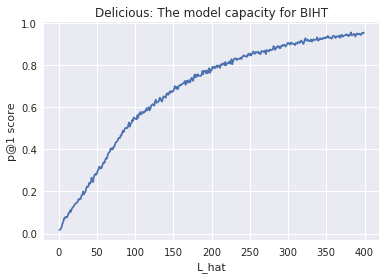

In [61]:
plt.plot(range(1,400), L_hat_free_score)
plt.xlabel('L_hat')
plt.ylabel('p@1 score')
plt.title('Delicious: The model capacity for BIHT')

In [57]:
tau=0.01;L_hat=200;pk=1
Iterate_free_score = Parallel(n_jobs=num_core)\
                    (delayed(validate_free)(L_hat, Y_tr, Y_te, tau, iterate, pk) for iterate in range(1, 20))

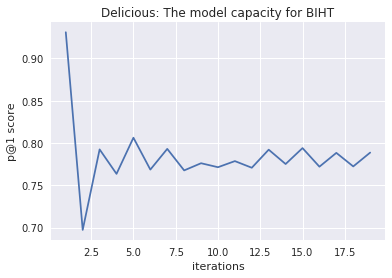

In [59]:
plt.plot(range(1,20), Iterate_free_score)
plt.xlabel('iterations')
plt.ylabel('p@1 score')
plt.title('Delicious: The model capacity for BIHT')

In [54]:
validate_free(L_hat,Y_tr,Y_te,tau=0.5,iterate=100,pk=1)

0.67974882260596547

In [52]:
L_hat

150

#### 3.3 optimize hyperparameter
use  k fold cross validation to optimize over 

In [ ]:
# validate the result with different L_hat under the same model
def validate(L_hat, pk=1, vote=10): # simple forkable parallel for loop body
    #k_fold = KFold(n_splits=fold)
    #print "L_hat is now {}\n".format(L_hat)
    p_sum = 0
   # for train_index, test_index in k_fold.split(X_tr):
    x_train = X_tr
    y_train = Y_tr
    x_test = X_te
    y_test = Y_te

    # map and create kNN index
    z_train = map_2_z(y_train, L_hat)
    # faiss brute force search
    knn_index = faiss.index_factory(z_train.shape[1], "Flat", faiss.METRIC_L2)   # build the index
    knn_index.add(z_train.astype('float32'))

    # construct model
    model = BMapModel.BM_Predictor(L_hat, knn_index, y_train)
    model.load_model(model_path)
    #predict and calculate p@k score
    y_pred = model.predict_y(x_test, vote, weighted=True)
    # precision@pk
    #p_sum += precision_at_k(y_test, y_pred, k=pk)
    return precision_at_k(y_test, y_pred, k=pk)


In [ ]:
# Optimize L_hat's value on the metric precision@k
pk=1
vote=40
L_hat_range = range(1, 120)

In [ ]:
L_hat_score = Parallel(n_jobs=num_core)(delayed(validate)(L_hat, pk, vote) for L_hat in L_hat_range)

In [ ]:
line_up, = plt.plot(range(1,120), L_hat_free_score, label='Model Capacity')
line_down, = plt.plot(range(1,120), L_hat_score, label='OvsA performance')
plt.legend(handles=[line_up, line_down])
plt.xlabel('L_hat')
plt.ylabel('precision@{}'.format(pk))
plt.title('Eurlex validation on L_hat')